<h2>Setup</h2>

In [1]:
# imports
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
from scipy.optimize import minimize
from scipy.stats import norm, t
from statsmodels.tsa.arima.model import ARIMA
from numpy.linalg import LinAlgError
import warnings
from time import time

In [2]:
warnings.filterwarnings("ignore", message='Provided `endog` series has been differenced')

In [3]:
# load data
avgs = np.load("avgs.npy")
maxs = np.load("maxs.npy")
mins = np.load("mins.npy")
ts = np.load("ts.npy")

dataset = avgs

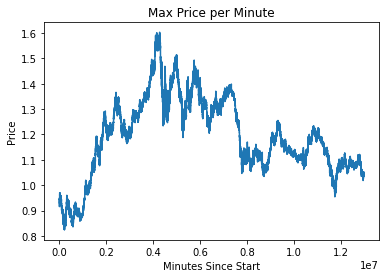

In [4]:
# plot data
plt.plot(dataset)
plt.xlabel("Minutes Since Start")
plt.ylabel("Price")
plt.title("Max Price per Minute")
plt.show()

<h2>ARIMA</h2>

In [5]:
def arima(time_series, horizon, p_max=3, d_max=2, q_max=3, verbose=False, predict_train_data=False):
    """
    Build an ARMA model with statsmodel and
    predict future n values.

    Parameters:
        filename (str): data filename
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model
        n (int): number of values to predict

    Return:
        aic (float): aic of optimal model
    """
    # model identification
    best_aic = np.inf
    best_model = None
    
    for p in range(p_max+1):
        for d in range(d_max+1):
            for q in range(q_max+1):
                if p == 0 and q == 0:
                    continue
                    
                try:
                    model = ARIMA(time_series, order=(p, d, q), trend=None, enforce_stationarity=None).fit(method="innovations_mle")

                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_model = model
                except LinAlgError as exc:
                    if verbose:
                        print(exc)
                    continue
                except ZeroDivisionError as exc:
                    if verbose:
                        print(exc)
                    continue
                except ValueError as exc:
                    if verbose:
                        print(exc)
                    continue
    if best_model is None:
        return None, None

    # prediction
    predictions = best_model.predict(start=0 if predict_train_data else len(time_series), end=len(time_series) + horizon - 1 if predict_train_data else len(time_series) - 1 + horizon)

    return predictions, best_model

<h2>Forecasting</h2>

In [7]:
# set parameters
N_SPLITS = 5
TRAIN_SIZE = 120
HORIZON = 10

In [8]:
# split data
start_ind = np.random.choice(len(dataset) - TRAIN_SIZE, size=N_SPLITS)
train_splits = np.empty((N_SPLITS, TRAIN_SIZE))
test_splits = np.empty((N_SPLITS, TRAIN_SIZE))
for i in range(N_SPLITS):
    train_splits[i] = dataset[start_ind[i]:start_ind[i]+TRAIN_SIZE]
    test_splits[i] = dataset[start_ind[i]+TRAIN_SIZE:start_ind[i]+2*TRAIN_SIZE]

Forecasting Split 1...
ARIMA Parameters Estimated


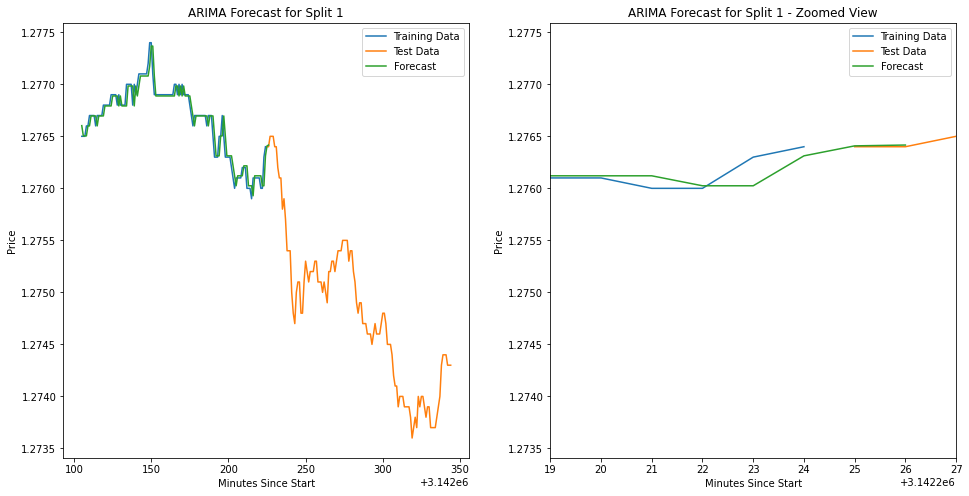

Forecasting Split 2...


/home/ryan/.local/lib/python3.10/site-packages/statsmodels/tsa/innovations/arma_innovations.py:179: RuntimeWarning: invalid value encountered in true_divide
  return func(endog, ar_params, ma_params, sigma2)
/home/ryan/.local/lib/python3.10/site-packages/statsmodels/tsa/innovations/arma_innovations.py:179: RuntimeWarning: invalid value encountered in true_divide
  return func(endog, ar_params, ma_params, sigma2)


ARIMA Parameters Estimated


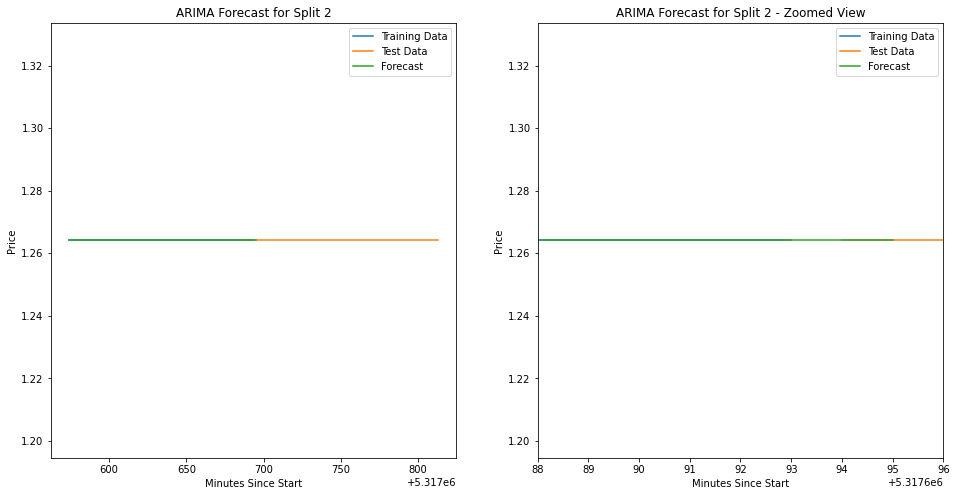

Forecasting Split 3...


KeyboardInterrupt: 

In [159]:
# forecast for each split
for i, (train_split, test_split) in enumerate(zip(train_splits, test_splits)):
    print(f"Forecasting Split {i+1}...")
    predictions, model = arima(train_split, HORIZON, predict_train_data=True)
    if predictions is not None:
        print("ARIMA Parameters Estimated")
    
        fig = plt.figure(figsize=(16, 8))
        ax1 = fig.add_subplot(121)
        ax1.plot(start_ind[i] + np.arange(TRAIN_SIZE), train_split, label="Training Data")
        ax1.plot(start_ind[i] + TRAIN_SIZE + np.arange(TRAIN_SIZE), test_split, label="Test Data")
        ax1.plot(start_ind[i] + np.arange(TRAIN_SIZE + HORIZON), predictions, label="Forecast")
        plt.xlabel("Minutes Since Start")
        plt.ylabel("Price")
        plt.title(f"ARIMA Forecast for Split {i+1}")
        plt.legend()

        ax2 = fig.add_subplot(122)
        ax2.plot(start_ind[i] + np.arange(TRAIN_SIZE), train_split, label="Training Data")
        ax2.plot(start_ind[i] + TRAIN_SIZE + np.arange(TRAIN_SIZE), test_split, label="Test Data")
        ax2.plot(start_ind[i] + np.arange(TRAIN_SIZE + HORIZON), predictions, label="Forecast")
        plt.xlabel("Minutes Since Start")
        plt.ylabel("Price")
        plt.xlim(xmin=start_ind[i] + TRAIN_SIZE - 3*HORIZON, xmax=start_ind[i] + TRAIN_SIZE + HORIZON)
        plt.title(f"ARIMA Forecast for Split {i+1} - Zoomed View")
        plt.legend()
        plt.show()
    else:
        print("Fit Failed")

<h2>Strategy</h2>

In [6]:
class Investor(object):
    def __init__(self, data, strategy, forecaster, principal, start_time, end_time, currency_name_1, currency_name_2):
        self.data = data # data is the time series price of currency 2 in currency 1
        self.strategy = strategy
        self.forecaster = forecaster
        self.balance_1 = principal[0]
        self.balance_2 = principal[1]
        self.history_1 = np.zeros(end_time-start_time + 1)
        self.history_1[0] = self.balance_1
        self.history_2 = np.zeros(end_time-start_time + 1)
        self.history_2[0] = self.balance_2
        self.start_time = start_time
        self.current_time = start_time
        self.end_time = end_time
        self.currency_name_1 = currency_name_1
        self.currency_name_2 = currency_name_2
        
    def invest(self):
        need_forecast = True
        while self.current_time < self.end_time:
            print_this_iteration = need_forecast
            if need_forecast:
                forecast = self.forecaster.new_forecast(self.data[self.current_time-self.forecaster.train_size+1:self.current_time+1])
            quantity, plan = self.strategy.new_transaction(forecast, self.data[self.current_time], self.balance_1, self.balance_2)
            need_forecast = len(plan) <= 1
            
            if print_this_iteration:
                print("Iteration", self.current_time - self.start_time + 1)
                print("Net Worth", self.balance_1 + self.data[self.current_time] * self.balance_2)
                print("Balance", self.balance_1, self.balance_2)
                print("Recommended Plan", plan)
                print("Current Price", self.data[self.current_time])
            self.balance_1 -= self.data[self.current_time] * quantity
            self.balance_2 += quantity
            
            self.current_time += 1
            if print_this_iteration:
                print("New Balance", self.balance_1, self.balance_2)
                print("----------")
            self.history_1[self.current_time - self.start_time] = self.balance_1
            self.history_2[self.current_time - self.start_time] = self.balance_2
            
            
    def plot_worth(self):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
        ax.plot(np.arange(len(self.history_1)), self.history_1, label=self.currency_name_1)
        ax.plot(np.arange(len(self.history_2)), self.history_2, label=self.currency_name_2)
        worth = self.history_1 + self.history_2 * self.data[self.start_time:self.end_time+1]
        ax.plot(np.arange(len(self.history_1)), worth, label="Net Worth")
        ax.set_xlabel("Minutes Since Simulation Start")
        ax.set_ylabel(self.currency_name_1)
        plt.legend()
        plt.show()
        
        return worth
        
    def plot_market(self):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
        ax.plot(
            np.arange(self.forecaster.train_size + self.end_time - self.start_time) - self.forecaster.train_size + 1,
            self.data[self.start_time - self.forecaster.train_size + 1:self.start_time + self.end_time - self.start_time + 1]
        )
        ax.set_xlabel("Minutes Since Simulation Start")
        ax.set_ylabel(self.currency_name_1)
        plt.show()
        
class Strategy(object):
    def __init__(self):
        self.plan = []
        
    def new_transaction(self, forecast, current_price, balance_1, balance_2):
        if not self.plan:
            self.new_plan(forecast, current_price, balance_1, balance_2)
        self.review_plan(forecast, current_price, balance_1, balance_2)
        plan = self.plan.copy()
        return self.plan.pop(0), plan
    
    def review_plan(self, forecast, current_price, balance_1, balance_2):
        pass
    
    def new_plan(self, forecast, current_price, balance_1, balance_2):
            self.plan = [0]
            
class RandomStrategy(Strategy):
    def __init__(self):
        super().__init__()
        
    def review_plan(self, forecast, current_price, balance_1, balance_2):
        epsilon = 1e-3
        if self.plan[0] > 0:
            if self.plan[0] * current_price > balance_1:
                self.plan[0] = (1 - epsilon) * balance_1 / current_price
                self.review_plan(forecast, current_price, balance_1, balance_2)
        elif self.plan[0] < 0:
            if self.plan[0] * -1 > balance_2:
                self.plan[0] = (1 - epsilon) * -balance_1 / current_price
                self.review_plan(forecast, current_price, balance_1, balance_2)
        
    def new_plan(self, forecast, current_price, balance_1, balance_2):
        choice = np.random.randint(2)
        if choice == 0:
            self.plan = [balance_1 / current_price]
        elif choice == 1:
            self.plan = [-balance_2]
        else:
            raise ValueError("new_plan method of RandomStrategy class has been implemented incorrectly")
    
class Strategy1(Strategy):
    """Buy as much as possible if the price is expected to lower, and sell as much as possible if the price is expected to raise, in excess of a specified threshold."""
    def __init__(self, athreshold):
        super().__init__()
        self.athreshold = athreshold
        self.last_transaction_price = None
        
    def review_plan(self, forecast, current_price, balance_1, balance_2):
        epsilon = 1e-3
        if self.plan[0] > 0:
            if self.plan[0] * current_price > balance_1:
                self.plan[0] = (1 - epsilon) * balance_1 / current_price
                self.review_plan(forecast, current_price, balance_1, balance_2)
        elif self.plan[0] < 0:
            if self.plan[0] * -1 > balance_2:
                self.plan[0] = (1 - epsilon) * -balance_1 / current_price
                self.review_plan(forecast, current_price, balance_1, balance_2)
        
    def new_plan(self, forecast, current_price, balance_1, balance_2):
        if self.last_transaction_price is None:
            self.last_transaction_price = current_price
        if forecast[-1] > current_price + self.athreshold:
            self.plan = [0] * len(forecast)
            self.plan[0] = balance_1 / current_price
        elif forecast[-1] < current_price - self.athreshold:
            self.plan = [0] * len(forecast)
            self.plan[0] = -balance_2
        else:
            self.plan = [0]
        self.last_transaction_price = current_price
            
class Forecaster(object):
    def __init__(self, train_size, horizon):
        self.train_size = train_size
        self.horizon = horizon
    
    def new_forecast(self, time_series):
        return time_series[-1] + (time_series[-1] - time_series[-2]) * np.ones(self.horizon)
    
class Forecaster1(Forecaster):
    def __init__(self, train_size, horizon):
        super().__init__(train_size, horizon)
        
    def new_forecast(self, time_series):
        return arima(time_series, self.horizon)[0]

<h2>Simulation</h2>

  0%|                                                    | 0/20 [00:00<?, ?it/s]

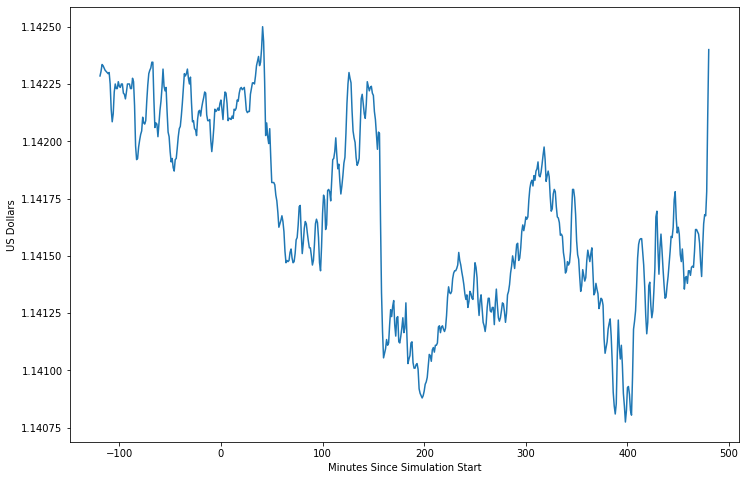

Iteration 1
Net Worth 1000000.0
Balance 1000000 0
Recommended Plan [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Current Price 1.14218
New Balance 1000000.0 0
----------
Iteration 11
Net Worth 1000000.0
Balance 1000000.0 0
Recommended Plan [875583.9050166581, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Current Price 1.1420949999999999
New Balance 0.0 875583.9050166581
----------


In [ ]:
NUM_TESTS = 20
profits = np.empty(NUM_TESTS)
profits2 = np.empty(NUM_TESTS)
baseline = np.empty(NUM_TESTS)
start = time()

for i in tqdm(range(NUM_TESTS)):
    TRAIN_SIZE = 120
    HORIZON = 10

    is_uniform = True
    while is_uniform:
        SIM_LENGTH = 480
        START_TIME = np.random.choice(len(dataset) - TRAIN_SIZE)
        is_uniform = (np.abs(dataset[START_TIME-TRAIN_SIZE+1:START_TIME+SIM_LENGTH+1] - dataset[START_TIME]) < 1e-4).all()

    strategy = Strategy1(athreshold=0)
    forecaster = Forecaster1(train_size=TRAIN_SIZE, horizon=HORIZON)
    investor = Investor(data=dataset, strategy=strategy, forecaster=forecaster, principal=(1_000_000, 0), start_time=START_TIME, end_time=START_TIME+SIM_LENGTH, currency_name_1="US Dollars", currency_name_2="Euros")
    investor.plot_market()
    investor.invest()
    worth = investor.plot_worth()
    profits[i] = worth[-1] - worth[0]
    print("Average Profit Thus Far:", profits[:i+1].mean())
    print(f"{i+1} tests completed in about {(time() - start)//60} minutes")
    
    strategy2 = RandomStrategy()
    forecaster2 = Forecaster(train_size=TRAIN_SIZE, horizon=HORIZON)
    investor2 = Investor(data=dataset, strategy=strategy2, forecaster=forecaster2, principal=(1_000_000, 0), start_time=START_TIME, end_time=START_TIME+SIM_LENGTH, currency_name_1="US Dollars", currency_name_2="Euros")
    investor2.invest()
    worth2 = investor2.plot_worth()
    profits2[i] = worth2[-1] - worth2[0]
    print("Average Random Profit Thus Far:", profits2[:i+1].mean())
    print(f"{i+1} tests completed in about {(time() - start)//60} minutes")
    
    baseline[i] = worth[0] / dataset[START_TIME] * dataset[START_TIME + SIM_LENGTH + 1]
    print("Average Baseline Thus Far:", baseline[:i+1].mean())
    
print("Average Profit:", profits.mean())
print("Average Random Profit:", profits2.mean())
print("Average Baseline:", baseline.mean())

In [336]:
dist = t(19)
t_stat = profits.mean() * (len(profits)**0.5) / (profits.var(ddof=1) ** 0.5)
p_value = dist.cdf(-np.abs(t_stat))
print(p_value)

0.05868535331097243
